In [4]:
# importing required modules
#import os

import pandas as pd
import numpy as np
import time
import copy
''' ================= initialization setting ======================'''
num_job=10 # number of jobs
num_mc=10 # number of machines

pt_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Processing Time",index_col =[0])
#print(pt_tmp)
ms_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Machines Sequence",index_col =[0])
#print(ms_tmp)
job_priority_duedate_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Priority and Due date",index_col =[0])
#print(job_priority_duedate_tmp)

# raw_input is used in python 2
population_size=20 #int(input('Please input the size of population: ') or 20) # default value is 20
crossover_rate=0.8 #float(input('Please input the size of Crossover Rate: ') or 0.8) # default value is 0.8
mutation_rate=0.3 #float(input('Please input the size of Mutation Rate: ') or 0.3) # default value is 0.3
mutation_selection_rate=0.4 #float(input('Please input the mutation selection rate: ') or 0.4)
num_mutation_jobs=round(num_job*num_mc*mutation_selection_rate)
num_iteration=1000 #int(input('Please input number of iteration: ') or 1000) # default value is 1000

# speed up the data search
# Below code can also be  written "pt = pt_tmp.as_matrix().tolist()"
pt=[list(map(int, pt_tmp.iloc[i])) for i in range(num_job)]
print(pt)
ms=[list(map(int,ms_tmp.iloc[i])) for i in range(num_job)]
print(ms)
job_priority_duedate=[list(job_priority_duedate_tmp.iloc[i]) for i in range(num_job)]
print(job_priority_duedate_tmp)
start_time = time.time()
'''===========function==============='''
'''-------non-dominated sorting function-------'''      
def non_dominated_sorting(population_size,chroms_obj_record):
    s,n={},{}
    front,rank={},{}
    front[0]=[]     
    for p in range(population_size*2):
        s[p]=[]
        n[p]=0
        for q in range(population_size*2):
            
            if ((chroms_obj_record[p][0]<chroms_obj_record[q][0] and chroms_obj_record[p][1]<chroms_obj_record[q][1]) or (chroms_obj_record[p][0]<=chroms_obj_record[q][0] and chroms_obj_record[p][1]<chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]<chroms_obj_record[q][0] and chroms_obj_record[p][1]<=chroms_obj_record[q][1])):
                if q not in s[p]:
                    s[p].append(q)
            elif ((chroms_obj_record[p][0]>chroms_obj_record[q][0] and chroms_obj_record[p][1]>chroms_obj_record[q][1]) or (chroms_obj_record[p][0]>=chroms_obj_record[q][0] and chroms_obj_record[p][1]>chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]>chroms_obj_record[q][0] and chroms_obj_record[p][1]>=chroms_obj_record[q][1])):
                n[p]=n[p]+1
        if n[p]==0:
            rank[p]=0
            if p not in front[0]:
                front[0].append(p)
    
    i=0
    while (front[i]!=[]):
        Q=[]
        for p in front[i]:
            for q in s[p]:
                n[q]=n[q]-1
                if n[q]==0:
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i=i+1
        front[i]=Q
                
    del front[len(front)-1]
    return front

'''--------calculate crowding distance function---------'''
def calculate_crowding_distance(front,chroms_obj_record):
    
    distance={m:0 for m in front}
    for o in range(2):
        obj={m:chroms_obj_record[m][o] for m in front}
        sorted_keys=sorted(obj, key=obj.get)
        distance[sorted_keys[0]]=distance[sorted_keys[len(front)-1]]=999999999999
        for i in range(1,len(front)-1):
            if len(set(obj.values()))==1:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]
            else:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]+(obj[sorted_keys[i+1]]-obj[sorted_keys[i-1]])/(obj[sorted_keys[len(front)-1]]-obj[sorted_keys[0]])
            
    return distance            
'''----------selection----------'''
def selection(population_size,front,chroms_obj_record,total_chromosome):   
    N=0
    new_pop=[]
    while N < population_size:
        for i in range(len(front)):
            N=N+len(front[i])
            if N > population_size:
                distance=calculate_crowding_distance(front[i],chroms_obj_record)
                sorted_cdf=sorted(distance, key=distance.get)
                sorted_cdf.reverse()
                for j in sorted_cdf:
                    if len(new_pop)==population_size:
                        break                
                    new_pop.append(j)              
                break
            else:
                new_pop.extend(front[i])
    
    population_list=[]
    for n in new_pop:
        population_list.append(total_chromosome[n])
    
    return population_list,new_pop


'''==================== main code ==============================='''
'''----- generate initial population -----'''
best_list,best_obj=[],[]
population_list=[]
for i in range(population_size):
    nxm_random_num=list(np.random.permutation(num_job*num_mc)) # generate a random permutation of 0 to num_job*num_mc-1
    population_list.append(nxm_random_num) # add to the population_list
    for j in range(num_job*num_mc):
        population_list[i][j]=population_list[i][j]%num_job # convert to job number format, every job appears m times

print(len(population_list))
num_iteration = 1
for n in range(num_iteration):           
    '''-------- two point crossover --------'''
    parent_list=copy.deepcopy(population_list)
    offspring_list=[]

    S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover
    for m in range(int(population_size/2)):
        #print(m)
        
        parent_1= population_list[S[2*m]][:]
        # print(len(parent_1))
        # print(parent_1)
        parent_2= population_list[S[2*m+1]][:]
        # print(len(parent_2))
        # print(parent_2)

        child_1=parent_1[:]
        child_2=parent_2[:]
        
        cutpoint=list(np.random.choice(num_job*num_mc, 2, replace=False))
        cutpoint.sort()

        #print(cutpoint)
        
    
        child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
        child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
        
        offspring_list.extend((child_1,child_2)) # append child chromosome to offspring list
        # print("hhhhhhh")
        # print(len(offspring_list))
        # print(offspring_list)

      
    '''----------repairment-------------'''
   
    # print("hhhhhhhhhmmmmmmmmm")
    # print(len(offspring_list))
    # print(offspring_list)
    for m in range(population_size):
        job_count={}
        larger,less=[],[] # 'larger' record jobs appear in the chromosome more than m times, and 'less' records less than m times.
        for i in range(num_job):
            if i in offspring_list[m]:
                count=offspring_list[m].count(i)
                pos=offspring_list[m].index(i)
                job_count[i]=[count,pos] # store the above two values to the job_count dictionary
            else:
                count=0
                job_count[i]=[count,0]
            if count>num_mc:
                larger.append(i)
            elif count<num_mc:
                less.append(i)
        # print("jkkk")
        # print(job_count[3][0])
        # print(larger)
        # print(less)        
        
        for k in range(len(larger)):
            chg_job=larger[k]
            while job_count[chg_job][0]>num_mc:
                for d in range(len(less)):
                    if job_count[less[d]][0]<num_mc:
                                          
                        offspring_list[m][job_count[chg_job][1]]=less[d]
                       
                        job_count[chg_job][1]=offspring_list[m].index(chg_job)
                        job_count[chg_job][0]=job_count[chg_job][0]-1
                        job_count[less[d]][0]=job_count[less[d]][0]+1                    
                    if job_count[chg_job][0]==num_mc:
                        break 
        # print(job_count)
        # print(offspring_list[m])
        # break       
    
    '''--------mutation--------'''   
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if mutation_rate <= mutation_prob:
            m_chg=list(np.random.choice(num_job*num_mc, num_mutation_jobs, replace=False)) # chooses the position to mutation
            t_value_last=offspring_list[m][m_chg[0]] # save the value which is on the first mutation position
            for i in range(num_mutation_jobs-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] # displacement
            
            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last # move the value of the first mutation position to the last mutation position   
                        
    
    '''--------fitness value(calculate  makespan and TWET)-------------'''
    total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list) # combine parent and offspring chromosomes
    chroms_obj_record={} # record each chromosome objective values as chromosome_obj_record={chromosome:[TWET,makespan]}
    for m in range(population_size*2):
        j_keys=[j for j in range(num_job)]
        # print("jjjjjj")
        # print(j_keys)
        key_count={key:0 for key in j_keys}
        #print(key_count)
        j_count={key:0 for key in j_keys}
        #print(j_count)
        m_keys=[j+1 for j in range(num_mc)]
        #print(m_keys)
        m_count={key:0 for key in m_keys}
        #print(m_count)
        d_record={} # record jobs earliness and tardiness time as d_record={job:[earliness time,tardiness time]}
        
        for i in total_chromosome[m]:
  
            gen_t=int(pt[i][key_count[i]])

            gen_m=int(ms[i][key_count[i]])
            
            j_count[i]=j_count[i]+gen_t
            m_count[gen_m]=m_count[gen_m]+gen_t
            
            
            if m_count[gen_m]<j_count[i]:
                m_count[gen_m]=j_count[i]
            elif m_count[gen_m]>j_count[i]:
                j_count[i]=m_count[gen_m]
            
            key_count[i]=key_count[i]+1
        
        for j in j_keys:
            if j_count[j]>job_priority_duedate[j][1]:
                job_tardiness=j_count[j]-job_priority_duedate[j][1]
                job_earliness=0
                d_record[j]=[job_earliness,job_tardiness]
            elif j_count[j]<job_priority_duedate[j][1]:
                job_tardiness=0
                job_earliness=job_priority_duedate[j][1]-j_count[j]
                d_record[j]=[job_earliness,job_tardiness]
            else:
                job_tardiness=0
                job_earliness=0
                d_record[j]=[job_earliness,job_tardiness]
        

        twet=sum((1/job_priority_duedate[j][0])*d_record[j][0]+job_priority_duedate[j][0]*d_record[j][1] for j in j_keys)
        makespan=max(j_count.values())
        chroms_obj_record[m]=[twet,makespan]

    '''-------non-dominated sorting-------'''   
    print(chroms_obj_record)   
    front=non_dominated_sorting(population_size,chroms_obj_record)
        
    '''----------selection----------'''
    population_list,new_pop=selection(population_size,front,chroms_obj_record,total_chromosome)
    new_pop_obj=[chroms_obj_record[k] for k in new_pop]    
    

    '''----------comparison----------'''
    if n==0:
        best_list=copy.deepcopy(population_list)
        best_obj=copy.deepcopy(new_pop_obj)
    else:            
        total_list=copy.deepcopy(population_list)+copy.deepcopy(best_list)
        total_obj=copy.deepcopy(new_pop_obj)+copy.deepcopy(best_obj)
        
        now_best_front=non_dominated_sorting(population_size,total_obj)
        best_list,best_pop=selection(population_size,now_best_front,total_obj,total_list)
        best_obj=[total_obj[k] for k in best_pop]
'''----------result----------'''
print(best_list)
# print(len(best_list[0]))
print(best_obj)
print('the elapsed time:%s'% (time.time() - start_time))


[[29, 78, 9, 36, 49, 11, 62, 56, 44, 21], [43, 90, 75, 11, 69, 28, 46, 46, 72, 30], [91, 85, 39, 74, 90, 10, 12, 89, 45, 33], [81, 95, 71, 99, 9, 52, 85, 98, 22, 43], [14, 6, 22, 61, 26, 69, 21, 49, 72, 53], [84, 2, 52, 95, 48, 72, 47, 65, 6, 25], [46, 37, 61, 13, 32, 21, 32, 89, 30, 55], [31, 86, 46, 74, 32, 88, 19, 48, 36, 79], [76, 69, 76, 51, 85, 11, 40, 89, 26, 74], [85, 13, 61, 7, 64, 76, 47, 52, 90, 45]]
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1, 3, 5, 10, 4, 2, 7, 6, 8, 9], [2, 1, 4, 3, 9, 6, 8, 7, 10, 5], [2, 3, 1, 5, 7, 9, 8, 4, 10, 6], [3, 1, 2, 6, 4, 5, 9, 8, 10, 7], [3, 2, 6, 4, 9, 10, 1, 7, 5, 8], [2, 1, 4, 3, 7, 6, 10, 9, 8, 5], [3, 1, 2, 6, 5, 7, 9, 10, 8, 4], [1, 2, 4, 6, 3, 10, 7, 8, 5, 9], [2, 1, 3, 7, 9, 10, 6, 4, 5, 8]]
       priority  due date
order                    
J1           10       919
 J2           5       785
 J3           1       907
 J4           5       849
 J5          10       887
 J6           1       783
J7            1       670
J8            5     

In [ ]:
!pip install pareto

  Created wheel for pareto: filename=pareto-1.1.1.post3-cp36-none-any.whl size=10171 sha256=325f8e41c7afe1a57c81b04e15c568e23b9c8d5e389d6e105f314d7440a3f908
  Stored in directory: /root/.cache/pip/wheels/e1/cd/14/43c6137695e7ccbb5891a97be6bd79429ce506048e957fe9b4
Successfully built pareto


[[4, 8, 3, 4, 6], [3, 7, 4, 3, 5], [2, 6, 1, 2, 4], [1, 4.5, 2, 1, 3]]
Sorted List
[[4, 8, 3, 4, 6]]
8
7
8
hmmmm
[[4, 8, 3, 4, 6], [3, 7, 4, 3, 5]]
6
7
hmmmm
[[4, 8, 3, 4, 6], [3, 7, 4, 3, 5], [2, 6, 1, 2, 4]]
4.5
6
hmmmm
[[4, 8, 3, 4, 6], [3, 7, 4, 3, 5], [2, 6, 1, 2, 4], [1, 4.5, 2, 1, 3]]
[[4, 8, 3, 4, 6], [3, 7, 4, 3, 5], [2, 6, 1, 2, 4], [1, 4.5, 2, 1, 3]]
plotting process
[4, 3, 2, 1]
[8, 7, 6, 4.5]
[13, 12, 7, 6]


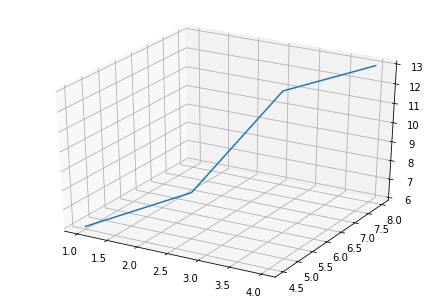

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#Depending on how many variables we change As,Bs,Xs, Ys and Zs
def plot_pareto_frontier(As, Bs, Xs, Ys, Zs, maxA = True, maxB = True, maxX=True, maxY=True, maxZ = True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[As[i],Bs[i],Xs[i], Ys[i], Zs[i]] for i in range(len(Xs))], reverse=maxX)
    print(sorted_list)
    pareto_front = [sorted_list[0]]
    print("Sorted List")
    print(pareto_front)
    print(pareto_front[-1][1])
    for pair in sorted_list[1:]:
        print(pair[1])
        # we have to change if else if we need
        if maxY:
            print(pareto_front[-1][1])
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
                print('hmmmm')
                
                print(pareto_front)
   
    
    '''Plotting process'''
    print(pareto_front)
    print('plotting process')
    pf_X = [pair[0] for pair in pareto_front]
    print(pf_X)
    pf_Y = [pair[1] for pair in pareto_front]
    print(pf_Y)
    pf_Z = [pair[2]+pair[3]+pair[4] for pair in pareto_front]
    print(pf_Z)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot(pf_X, pf_Y, pf_Z)
    plt.show()


As = [1,2,3,4]
Bs = [4.5,6,7,8]  
Xs = [2,1,4,3]
Ys = [1,2,3,4]
Zs = [3,4,5,6]


plot_pareto_frontier(As,Bs, Xs,Ys,Zs)

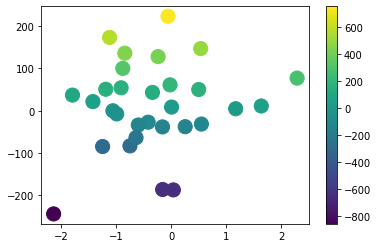

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2)

## generate a random data set
x, y = np.random.randn(2, 30)
y *= 100
z = 11*x + 3.4*y - 4 + np.random.randn(30) ##the model

fig, ax = plt.subplots()
scat = ax.scatter(x, y, c=z, s=200, marker='o')
fig.colorbar(scat)

plt.show()

In [ ]:
import operator
import copy
import time
import random

def select_dominated(a,b):
    ge = all(map(operator.ge, a, b))
    le = all(map(operator.le, a, b))
    # return dominated
    return b if ge else a if le else 'indifferent'

def paretoFront(a):
    b = copy.deepcopy(a)
    if len(a) > 1:
        for i in range(len(a)):
            for j in range(i,len(a)):
                if i != j:
                    try:
                        b.remove(select_dominated(a[i],a[j]))
                    except:
                        ""
    return b

set = []
for i in range(1000):
    set.append([random.random(),random.random(),random.random()])

t0 = time.time()
print( len(set),"->",len(paretoFront(set)),"in",time.time()-t0,"seconds")

1000 -> 23 in 1.5313048362731934 seconds


In [ ]:
import numpy as np

def pareto_frontier_multi(myArray):
    # Sort on first dimension
    myArray = myArray[myArray[:,0].argsort()]
    print('my array')
    print(myArray)
    # Add first row to pareto_frontier
    pareto_frontier = myArray[0:1,:]
    print('pareto_frontier')
    print(pareto_frontier)
    # Test next row against the last row in pareto_frontier
    for row in myArray[1:,:]:
        if sum([row[x] >= pareto_frontier[-1][x]
                for x in range(len(row))]) == len(row):
            # If it is better on all features add the row to pareto_frontier
            pareto_frontier = np.concatenate((pareto_frontier, [row]))
    return pareto_frontier

myArray = np.array([[2,1,1],[1,2,2],[3,4,4],[4,3,3]])
print(pareto_frontier_multi(myArray))

my array
[[1 2 2]
 [2 1 1]
 [3 4 4]
 [4 3 3]]
pareto_frontier
[[1 2 2]]
[[1 2 2]
 [3 4 4]]
